# Discriminator Tutorial

In [30]:
%load_ext autoreload
%autoreload 2
import numpy as np
from qiskit.providers import BaseBackend
from qiskit.providers.models import QasmBackendConfiguration
from qiskit.result import Result
from qiskit.test import QiskitTestCase
from qiskit_experiments.measurement.discriminator import Discriminator
from qiskit_experiments.measurement.discriminator import DiscriminatorAnalysis
from qiskit_experiments.composite import ParallelExperiment
from qiskit.providers.backend import BackendV1 as Backend
from typing import List, Tuple
from qiskit.providers.options import Options
from qiskit.qobj.utils import MeasLevel

from abc import abstractmethod
from qiskit import QuantumCircuit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
from qiskit_experiments.test.mock_iq_backend import MockIQBackend

In [52]:
class DiscriminatorBackend(MockIQBackend):
    """
    A simple backend that generates gaussian data for discriminator tests
    """

    def __init__(self, iq_cluster_centers: Tuple[float, float, float, float] = (1.0, 1.0, -1.0, -1.0),iq_cluster_width: float = 0.2):
        """
        Initialize the discriminator backend
        """
        super().__init__(iq_cluster_centers, iq_cluster_width)

    def sample_gaussian(self, centroid=np.array([0,0]), cov=np.array([[0.1,0],[0,0.1]]), size=1):
        """
        Draws random samples from a gaussian distribution.
        """
        return self.rng.multivariate_normal(centroid, cov, size)

    def _compute_probability(self, circuit: QuantumCircuit) -> float:
        """Returns the probability based on the frequency."""
        if circuit.data[0][0].name == "x":
            return 1
        elif circuit.data[0][0].name == "measure":
            return 0
        else:
            raise BaseException("Unexpected circuit component")


## Run Example Discriminator Experiment on One Qubit

In [54]:
backend = DiscriminatorBackend()
exp = Discriminator(1)
lda_res = exp.run(
    backend,
    shots=1000,
    discriminator_type="LDA"
)

print(lda_res)

TypeError: list indices must be integers or slices, not tuple

---------------------------------------------------
Experiment: Discriminator
Experiment ID: d16a4469-9328-4973-91cd-7a8b3a4f296a
Status: DONE
Circuits: 2
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- discriminator: QuadraticDiscriminantAnalysis()
- rotations: [array([[-0.99992655, -0.0121197 ],
       [-0.0121197 ,  0.99992655]]), array([[-0.99991046, -0.01338155],
       [ 0.01338155, -0.99991046]])]
- score: 0.988
- plt: AxesSubplot(0.125,0.125;0.775x0.755)
- success: True


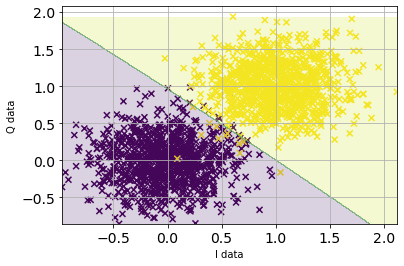

In [9]:
from qiskit_experiments.measurement.discriminator import Discriminator, DiscriminatorAnalysis

backend = DiscriminatorBackend(2)
exp = Discriminator(1)
exp.set_analysis_options(discriminator_type="QDA")

qda_res = exp.run(
    backend,
    shots=1000
)
print(qda_res)

## Run Discriminator Experiments in Parallel 

---------------------------------------------------
Experiment: ParallelExperiment
Experiment ID: df51a01c-6af9-4fa7-969d-b27af682db2e
Status: DONE
Component Experiments: 3
Circuits: 2
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- experiment_types: ['Discriminator', 'Discriminator', 'Discriminator']
- experiment_ids: ['037e196e-a7ce-4333-85d8-303cca0323b8', '2fa8a668-9243-4126-8c15-ecbc048132ce', '7bcc45d6-8dde-469e-937a-7c46390f7d4b']
- experiment_qubits: [(0,), (1,), (2,)]
- success: True


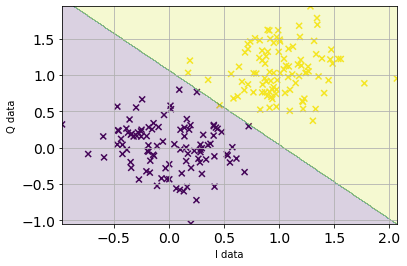

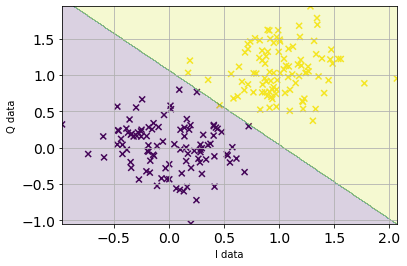

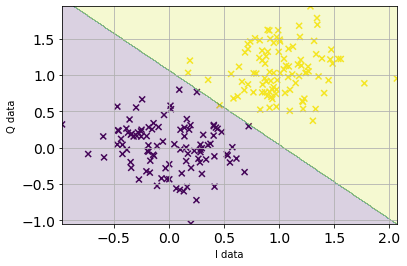

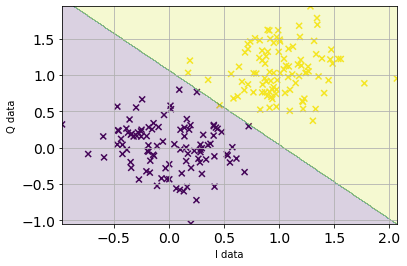

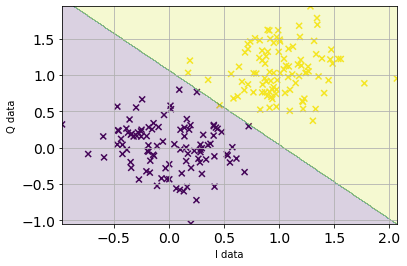

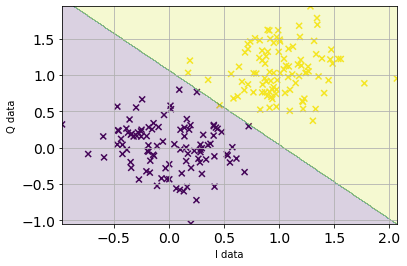

In [10]:
from qiskit_experiments.measurement.discriminator import Discriminator, DiscriminatorAnalysis
from qiskit_experiments.composite import ParallelExperiment

exps = [Discriminator(i) for i in range(3)]

par_exp = ParallelExperiment(exps)
par_expdata = par_exp.run(backend, shots=100)
print(par_expdata)

## Use Data Processor Discriminator Node

In [12]:
lda_res.data(0)

{'counts': {'0': 1000},
 'memory': array([[[ 0.03975939, -0.04177523]],
 
        [[ 0.20251942,  0.03317233]],
 
        [[-0.16939353,  0.1143464 ]],
 
        ...,
 
        [[ 0.39519783,  0.2373713 ]],
 
        [[-0.17576437, -0.63840429]],
 
        [[-0.28758625,  0.11676057]]]),
 'metadata': {'experiment_type': 'Discriminator',
  'ylabel': '0',
  'qubit': 1,
  'meas_level': <MeasLevel.KERNELED: 1>,
  'meas_return': 'single'}}

In [11]:
from qiskit_experiments.data_processing.data_processor import DataProcessor
from qiskit_experiments.data_processing.exceptions import DataProcessorError
from qiskit_experiments.data_processing.nodes import (
    ToReal,
    ToImag,
    Probability,
    Discriminator
)

# LDA node
processor = DataProcessor("memory", [Discriminator(lda_res)])
processor.append(Probability("0"))
datum = processor(lda_res.data(0))

print(datum)

# QDA node
processor = DataProcessor("memory", [Discriminator(qda_res)])
processor.append(Probability("0"))
datum = processor(qda_res.data(0))

print(datum)

TypeError: _process() takes from 2 to 3 positional arguments but 1001 were given

Using a parallel experiment to discriminate over multiple qubits:

In [95]:
processor = DataProcessor("memory", [Discriminator(par_expdata)])
processor.append(Probability("000"))
datum = processor(par_expdata.data(0))

print(datum)

(0.95, 0.021794494717703377)


In [36]:
from qiskit_experiments.data_processing.data_processor import DataProcessor
from qiskit_experiments.data_processing.exceptions import DataProcessorError
from qiskit_experiments.data_processing.nodes import (
    ToReal,
    ToImag,
    Probability,
    Discriminator
)
processor = DataProcessor("memory", [Discriminator(par_expdata)])
processor.append(Probability("000"))
datum = processor(par_expdata.data(0))

print(datum)

[autoreload of qiskit_experiments.data_processing.nodes failed: Traceback (most recent call last):
  File "/Users/Helena.Zhang@ibm.com/Documents/GitHub/playground/pydantic-workshop/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/Helena.Zhang@ibm.com/Documents/GitHub/playground/pydantic-workshop/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/Helena.Zhang@ibm.com/Documents/GitHub/playground/pydantic-workshop/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/Helena.Zhang@ibm.com/Documents/GitHub/playground/pydantic-workshop/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Users/Helena.Zhang@ibm.com/Documents/GitHub/playground/pydantic-w

TypeError: _process() takes from 2 to 3 positional arguments but 101 were given